In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import  metrics
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

##  **Stroke prediction**
Predykcja udaru na podstawie danych: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [2]:
data = pd.read_csv('./projekt_dane/healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Aby lekko ograniczyć i zmniejszyć rozmiar danych, predykcja będzie odbywałą sie tylko dla osób dorosłych (>18lat)

In [4]:
data.drop(data[(data.age < 18)].index, inplace=True)

In [5]:
data['work_type'].value_counts()

Private          2791
Self-employed     807
Govt_job          651
Never_worked        5
Name: work_type, dtype: int64

In [6]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  181
smoking_status         0
stroke                 0
dtype: int64

Ogólnie rzecz biorąc, według badań bardziej narażone na udar są kobiety - jest to połączone z faktem, że statystycznie są one bardziej narażone na czynniki (społeczne/fizyczne), które mogą do niego doprowadzić.

In [7]:
data['gender'].value_counts()

Female    2576
Male      1677
Other        1
Name: gender, dtype: int64

<Axes: >

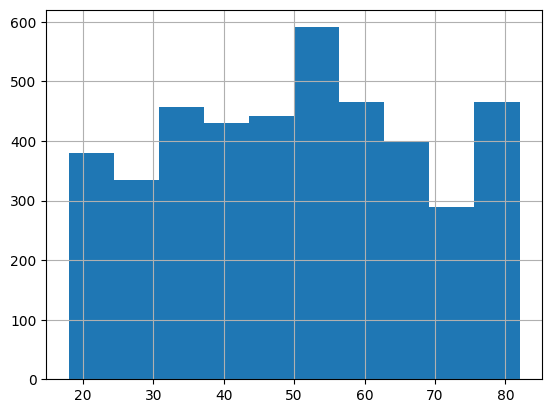

In [8]:
data.age.hist()

Nadciśnienie jest rozpatrywane jako jeden z głównych czynników mających wpływ na udar.
Ponadto ryzyko dla kobiet z nadciśnieniem jest większe.

In [9]:
data['hypertension'].value_counts()

0    3757
1     497
Name: hypertension, dtype: int64

In [10]:
data['heart_disease'].value_counts()

0    3979
1     275
Name: heart_disease, dtype: int64

Statystycznie osoby, które nie były nigdy w związku małżeńskim mają większe ryzyko udaru.

In [11]:
data['ever_married'].value_counts()

Yes    3353
No      901
Name: ever_married, dtype: int64

In [12]:
data['work_type'].value_counts()

Private          2791
Self-employed     807
Govt_job          651
Never_worked        5
Name: work_type, dtype: int64

In [13]:
data['Residence_type'].value_counts()

Urban    2169
Rural    2085
Name: Residence_type, dtype: int64

In [14]:
data['smoking_status'].value_counts()

never smoked       1752
Unknown             862
formerly smoked     860
smokes              780
Name: smoking_status, dtype: int64

In [15]:
data['stroke'].value_counts()

0    4007
1     247
Name: stroke, dtype: int64

In [16]:
data.drop(['id'], axis=1, inplace=True)
data.drop(data[(data['gender'] == 'Other')].index, inplace=True)

Cukrzyca wpływa na ryzyko udaru. Z uwagi na to, że mamy do dyspozycji **średni** poziom cukru we krwi (na podstawie wyników *avg_glucose_level* - zakładam, że glukoza badana była na czczo), klasyfikuję osoby do jednej z 3 grup: 
- 'w normie' (<=99mg/dL), 
- 'stan przedcukrzycowy' \[100mg/dL;125mg/dL\] , 
- 'cukrzyca' (>=126mg/dL)

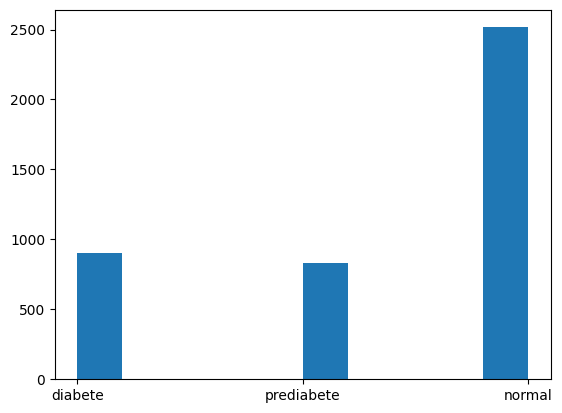

In [17]:
max_gl = max(data.avg_glucose_level)
diabete_status = pd.cut(data.avg_glucose_level,bins=[0,99,125,max_gl],labels=['normal','prediabete','diabete'])

data['avg_glucose_level'] = diabete_status
data.rename(columns={'avg_glucose_level': 'diabete_status'}, inplace=True)

plt.hist(diabete_status)
plt.show()

In [18]:
X = data.drop(['stroke'], axis=1)
y = data.stroke

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

<BarContainer object of 1 artists>

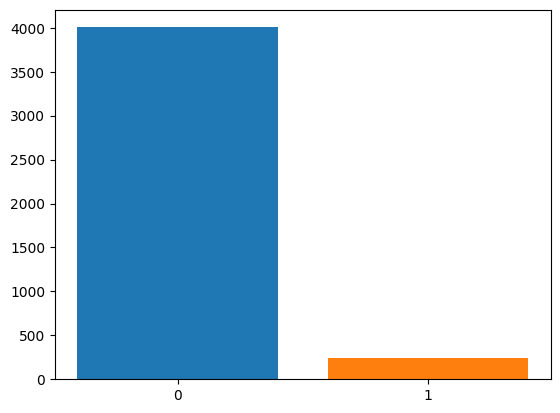

In [19]:
fig, ax = plt.subplots()
ax.bar(x = '0', height = len(y[y == 0]))
ax.bar(x = '1', height = len(y[y == 1]))

In [20]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [21]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [22]:
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse_output=False, handle_unknown = 'ignore', dtype='int', drop="if_binary")),
    ])

Palenie papierosów, wg badań, również wywiera duży wpływ na wystąpnienie udaru, zatem jest to dana kluczowa. Co więcej, **palenie bierne wywiera niemalże taki sam wpływ jak czynne.** \
Jako, że autor datasetu nie podaje regionu z jakiego zostały zebrane dane, ciężko wywnioskować jaki może być odsetek osób palących na tym obszarze, a co za tym idzie jak bardzo ludzie narażeni są na bierne wdychanie dymu papierosowego.
W jednym z komentarzu znalazłam odniesienie do Bangladeshu, gdzie odsetek palących jest duży (ok 50%), zakładam, że każdy w jakimś stopniu ma kontakt z dymem => wartość 'never smoked' niekoniecznie gwarantuje, że ktoś nie miał tego kontaktu w ogóle.
*Zakładam, że 'smokes' oznacza, że ktoś pali regularnie (np. codziennie) w większych ilościach*, czego nie można wprost założyć dla 'nieznanych' danych => w miejsce 'Unknown' wstawiam 'never smoked'.

In [23]:
class UnknownTransformer(BaseEstimator, TransformerMixin):  
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        _X = X.copy()
        _X.loc[X.smoking_status == 'Unknown', 'smoking_status'] = 'never smoked'
        return _X

In [24]:
smoke_pipeline = Pipeline([
        ("custom_transformer", UnknownTransformer()),
        ("cat_encoder", OneHotEncoder(sparse_output=False, handle_unknown = 'ignore', dtype='int'))
    ])

In [25]:
oversample = SMOTE(k_neighbors=5)

In [26]:
#undersample = RandomUnderSampler()

In [27]:
def get_col_index(array):
    return data.columns.get_indexer(array)

In [28]:
preprocess_pipeline = Pipeline([
        ("preprocess", ColumnTransformer([
            ("num_pipeline", num_pipeline, get_col_index(["age",  "bmi"])),
            ("cat_pipeline", cat_pipeline, get_col_index(["gender", "ever_married", "work_type", "Residence_type", "diabete_status"])),
            ("smoke_pipeline", smoke_pipeline, get_col_index(["smoking_status"]))
        ])),
        ("oversample", oversample),
        #("undersample", undersample),
        ('std_scaler', StandardScaler())
    ])

In [29]:
preprocess_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  array([1, 8], dtype=int64)),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   MostFrequentImputer()),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype='int',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  array([0, 4, 5, 6, 7], dtype=int64)),
                                                 ('smoke_pipeline',
                                                  Pipeline(steps=[('custom_transformer',
                                                                   UnknownTransformer()),
                                                                  ('cat_encoder',
                                                                   OneHotEncoder(dtype='int',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  array([9], dtype=int64))])),
                ('oversample', SMOTE()), ('std_scaler', StandardScaler())])

In [30]:
kfold = StratifiedKFold(n_splits=5)

## Modelowanie 

    - LogisticRegression
    - SVM rbf
    - RandomForest
    - VotingClassifier (soft; na podstawie 3 powyższych)
    - XGBoost

In [31]:
log_pipe = deepcopy(preprocess_pipeline)
log_pipe.steps.append(['classifier', LogisticRegression(max_iter=10000)])

log_params = { 'classifier__C': [1, 2, 3, 4, 5, 6, 10, 25, 50, 100] }

log_clf = GridSearchCV(log_pipe, log_params, cv=kfold, scoring='recall', return_train_score=True)

log_clf.fit(X_train, y_train)
log_clf.best_params_

{'classifier__C': 50}

In [32]:
svm_pipe = deepcopy(preprocess_pipeline)
svm_pipe.steps.append(['classifier', SVC(probability=True)])

svm_params = {'classifier__C': [ 0.001, 0.01, 0.05],
              'classifier__gamma': [0.001, 0.01, 0.1, 1]}

svm_clf = GridSearchCV(svm_pipe, svm_params, cv=kfold, scoring='recall', return_train_score=True)

svm_clf.fit(X_train, y_train)
svm_clf.best_params_

{'classifier__C': 0.01, 'classifier__gamma': 0.01}

In [33]:
rf_pipe = deepcopy(preprocess_pipeline)
rf_pipe.steps.append(['classifier', RandomForestClassifier(n_jobs=-1)])

rf_params = {'classifier__n_estimators': [10, 25, 50, 75, 90, 100],
             'classifier__max_leaf_nodes': [2, 4, 8, 16, 32, 64] }

rf_clf = GridSearchCV(rf_pipe, rf_params, cv=kfold, scoring='recall', return_train_score=True)

rf_clf.fit(X_train, y_train)
rf_clf.best_params_

{'classifier__max_leaf_nodes': 2, 'classifier__n_estimators': 100}

In [34]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf.best_estimator_), ('rf', rf_clf.best_estimator_), ('svc', svm_clf.best_estimator_)], voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocess',
                                               ColumnTransformer(transformers=[('num_pipeline',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median'))]),
                                                                                array([1, 8], dtype=int64)),
                                                                               ('cat_pipeline',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 MostFrequentImputer()),
                                                                                                ('cat_encoder',
                                                                                                 OneHotEncoder(drop='if_binary',
                                                                                                               dtype='int',
                                                                                                               handle_unknown='ignore',...
                                                                                array([0, 4, 5, 6, 7], dtype=int64)),
                                                                               ('smoke_pipeline',
                                                                                Pipeline(steps=[('custom_transformer',
                                                                                                 UnknownTransformer()),
                                                                                                ('cat_encoder',
                                                                                                 OneHotEncoder(dtype='int',
                                                                                                               handle_unknown='ignore',
                                                                                                               sparse_output=False))]),
                                                                                array([9], dtype=int64))])),
                                              ('oversample', SMOTE()),
                                              ('std_scaler', StandardScaler()),
                                              ['classifier',
                                               SVC(C=0.01, gamma=0.01,
                                                   probability=True)]]))],
                 voting='soft')

In [35]:
xg_pipe = deepcopy(preprocess_pipeline)
xg_pipe.steps.append(['classifier', XGBClassifier()])

xg_params = {'classifier__n_estimators': [2, 4, 5, 10, 15, 20, 25],
             'classifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.75, 0.1, 0.25, 0.5]}

xg_clf = GridSearchCV(xg_pipe, xg_params, cv=kfold, scoring='recall', return_train_score=True)

xg_clf.fit(X_train, y_train)
xg_clf.best_params_

{'classifier__learning_rate': 0.001, 'classifier__n_estimators': 10}

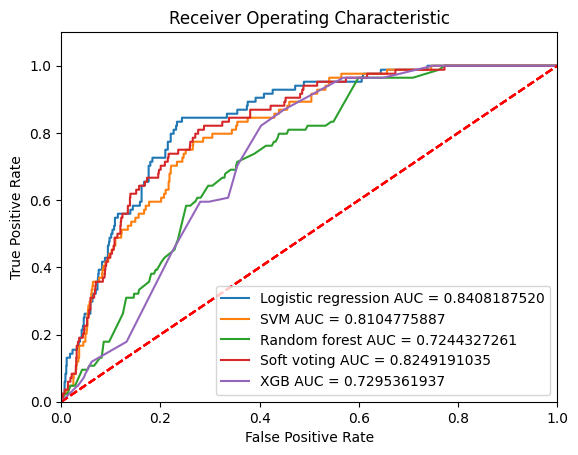

In [36]:
models = []
models.append(('Logistic regression', log_clf.best_estimator_))
models.append(('SVM', svm_clf.best_estimator_))
models.append(('Random forest', rf_clf.best_estimator_))
models.append(('Soft voting', voting_clf))
models.append(('XGB', xg_clf.best_estimator_))


precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []

for name, model in models:
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))

        probs = model.predict_proba(X_test)
        preds = probs[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_score.append(roc_auc)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, label = '%s AUC = %0.10f' % (name, roc_auc))
        plt.legend(loc = 'lower right')
        plt.plot([0.0, 1.0], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

plt.show()

In [37]:
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc': roc_auc_score
    }

df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Logistic regression', 'SVM', 'Random forest', 'Soft voting', 'XGB' ])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc
0,Logistic regression,0.167453,0.845238,0.279528,0.713166,0.840819
1,SVM,0.138889,0.833333,0.238095,0.648903,0.810478
2,Random forest,0.140401,0.583333,0.226328,0.737461,0.724433
3,Soft voting,0.166667,0.821429,0.277108,0.717868,0.824919
4,XGB,0.090909,0.047619,0.062500,0.905956,0.729536


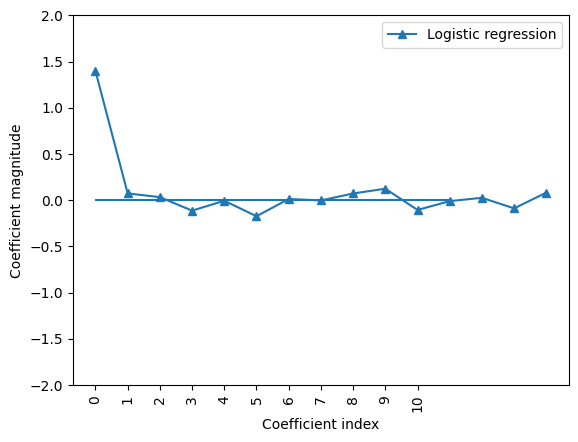

In [63]:
plt.plot(log_clf.best_estimator_.named_steps['classifier'].coef_.T, '^-', label='Logistic regression')
plt.xticks(range(data.shape[1]), rotation=90)
plt.hlines(0, 0, data.shape[1])
plt.ylim(-2, 2)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.show()

In [64]:
print(log_pipe.named_steps['preprocess'].named_transformers_.num_pipeline.get_feature_names_out())
print(log_pipe.named_steps['preprocess'].named_transformers_.cat_pipeline.named_steps['cat_encoder'].get_feature_names_out())        
print(log_pipe.named_steps['preprocess'].named_transformers_.smoke_pipeline.named_steps['cat_encoder'].get_feature_names_out())

['age' 'bmi']
['gender_Male' 'ever_married_Yes' 'work_type_Govt_job'
 'work_type_Never_worked' 'work_type_Private' 'work_type_Self-employed'
 'Residence_type_Urban' 'diabete_status_diabete' 'diabete_status_normal'
 'diabete_status_prediabete']
['smoking_status_formerly smoked' 'smoking_status_never smoked'
 'smoking_status_smokes']


### Podsumowanie

Ze względu na to, że przewidujemy zagrożenie życia udare, postanowiłam kierować się metryką **recall** - GridSearch z scoring ustawionym na *accuracy* jak i *f1* wybierał klasyfikatory z presision oraz recal na poziomie 0.1.

Z powyższych danych (na podstawie f1-score i roc_auc) wynika, że najlepiej poradził sobie model regresji logistycznej, a zaraz za nią model przewidujący na podstawie prawdopodobieństw z regresji, SVM i RandomForest, jak również SVM.

Zwracając uwagę na warość accuracy najlepiej wypada XGBoost, jednakże patrząc na metrykę f1-score czy roc-auc, wynik jest zdecydowanie najgorszy. Recall również utrzymuje się na najniższym poziomie
Presision w każdym modelu utrzymuje się na podobnym poziomie - przekłamywanie pozytywnych wyników, co jeszcze nas nie martwi - lepiej, żeby kilku pacjentów więcej się porządnie przebadało niż dostało udaru.

## Sieci neuronowe

In [38]:
X_train_n, X_valid_n, y_train_n, y_valid_n = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [39]:
from sklearn.pipeline import Pipeline as PipelineSk

keras_preprocess_pipeline = PipelineSk([
        ("preprocess", ColumnTransformer([
            ("num_pipeline", num_pipeline, get_col_index(["age",  "bmi"])),
            ("cat_pipeline", cat_pipeline, get_col_index(["gender", "ever_married", "work_type", "Residence_type", "diabete_status"])),
            ("smoke_pipeline", smoke_pipeline, get_col_index(["smoking_status"]))
        ])),
    ])

In [40]:
process = keras_preprocess_pipeline.fit(X_train_n)
X_train_processed = process.transform(X_train_n)
X_valid_processed = process.transform(X_valid_n)
X_test_processed = process.transform(X_test)

X_train_processed, y_train_n = oversample.fit_resample(X_train_processed, y_train_n)
#X_train_processed, y_train = undersample.fit_resample(X_train_processed, y_train)

scaler = StandardScaler()
scaler.fit(X_train_processed)
X_train_scaled = scaler.transform(X_train_processed)
X_valid_scaled = scaler.transform(X_valid_processed)
X_test_scaled = scaler.transform(X_test_processed)

In [41]:
def CreateModel_1():
    model = Sequential([
        layers.Dense(25, activation='relu', input_dim=X_train_scaled.shape[1]),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.summary()

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [42]:
model = CreateModel_1()
history = model.fit(X_train_scaled, y_train_n, validation_data= (X_valid_scaled, y_valid_n), batch_size=16, epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                400       
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 671
Trainable params: 671
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
316/316 [==============================] - 3s 5ms/step - loss: 0.5949 - accuracy: 0.6920 - val_loss: 0.4540 - val_accuracy: 0.7383
Epoch 2/30
316/316 [==============================] - 1s 3ms/step - loss: 0.4899 - accuracy: 0.7646 - val_loss: 0.4378 - val_accuracy: 0.7450
Epoch 3/30
316/316 [==================

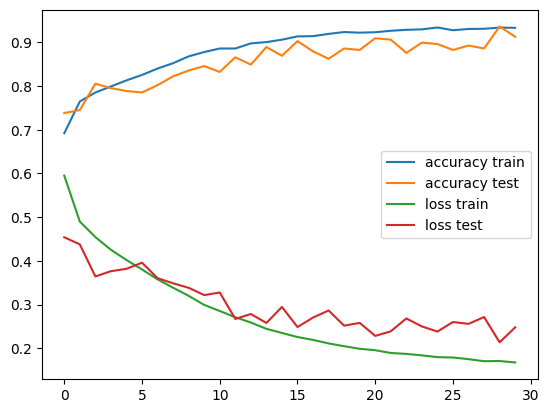

In [43]:
plt.plot(history.history['accuracy'], label = "accuracy train")
plt.plot(history.history['val_accuracy'], label = "accuracy test")
plt.plot(history.history['loss'], label = "loss train")
plt.plot(history.history['val_loss'], label = "loss test")

plt.legend()
plt.show()

In [44]:
model.evaluate(X_test_scaled, y_test)

40/40 [==============================] - 0s 3ms/step - loss: 0.2991 - accuracy: 0.8848


[0.2991233468055725, 0.8847962617874146]

In [45]:
metrics.accuracy_score(y_true= y_test, y_pred= (model.predict(X_test_scaled) > 0.5).astype("int32") )

40/40 [==============================] - 0s 3ms/step


0.8847962382445141

In [54]:
def CreateModel_2():
    model = Sequential([
        layers.Dense(23, input_dim=X_train_scaled.shape[1]),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.3),
        layers.Dense(10),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.3),
        layers.Dense(10),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [55]:
model_2 = CreateModel_2()
history_2 = model_2.fit(X_train_scaled, y_train_n, validation_data= (X_valid_scaled, y_valid_n), batch_size=32, epochs=400)

Epoch 1/400
158/158 [==============================] - 5s 8ms/step - loss: 0.7415 - accuracy: 0.5178 - val_loss: 0.6706 - val_accuracy: 0.6141
Epoch 2/400
158/158 [==============================] - 1s 6ms/step - loss: 0.6907 - accuracy: 0.5692 - val_loss: 0.6245 - val_accuracy: 0.6980
Epoch 3/400
158/158 [==============================] - 1s 6ms/step - loss: 0.6577 - accuracy: 0.6027 - val_loss: 0.5782 - val_accuracy: 0.6913
Epoch 4/400
158/158 [==============================] - 1s 5ms/step - loss: 0.6292 - accuracy: 0.6430 - val_loss: 0.5511 - val_accuracy: 0.6779
Epoch 5/400
158/158 [==============================] - 1s 5ms/step - loss: 0.6074 - accuracy: 0.6717 - val_loss: 0.5178 - val_accuracy: 0.6913
Epoch 6/400
158/158 [==============================] - 1s 5ms/step - loss: 0.5930 - accuracy: 0.6818 - val_loss: 0.5205 - val_accuracy: 0.6846
Epoch 7/400
158/158 [==============================] - 1s 5ms/step - loss: 0.5701 - accuracy: 0.7055 - val_loss: 0.4963 - val_accuracy: 0.6879

Epoch 58/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4351 - accuracy: 0.7959 - val_loss: 0.3668 - val_accuracy: 0.8087
Epoch 59/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4488 - accuracy: 0.7989 - val_loss: 0.3717 - val_accuracy: 0.7987
Epoch 60/400
158/158 [==============================] - 1s 6ms/step - loss: 0.4455 - accuracy: 0.7939 - val_loss: 0.3634 - val_accuracy: 0.7987
Epoch 61/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4412 - accuracy: 0.7959 - val_loss: 0.3606 - val_accuracy: 0.8087
Epoch 62/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4511 - accuracy: 0.7967 - val_loss: 0.3607 - val_accuracy: 0.8020
Epoch 63/400
158/158 [==============================] - 1s 6ms/step - loss: 0.4572 - accuracy: 0.7909 - val_loss: 0.3532 - val_accuracy: 0.7987
Epoch 64/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4380 - accuracy: 0.7983 - val_loss: 0.3638 - val_accuracy:

Epoch 115/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4281 - accuracy: 0.8052 - val_loss: 0.3343 - val_accuracy: 0.8087
Epoch 116/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4319 - accuracy: 0.7992 - val_loss: 0.3257 - val_accuracy: 0.8289
Epoch 117/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4216 - accuracy: 0.8062 - val_loss: 0.3232 - val_accuracy: 0.8356
Epoch 118/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8010 - val_loss: 0.3246 - val_accuracy: 0.8322
Epoch 119/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8091 - val_loss: 0.3182 - val_accuracy: 0.8221
Epoch 120/400
158/158 [==============================] - 1s 6ms/step - loss: 0.4308 - accuracy: 0.7961 - val_loss: 0.3256 - val_accuracy: 0.8154
Epoch 121/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4155 - accuracy: 0.8046 - val_loss: 0.3281 - val_ac

158/158 [==============================] - 1s 7ms/step - loss: 0.4172 - accuracy: 0.8131 - val_loss: 0.3178 - val_accuracy: 0.8154
Epoch 172/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4182 - accuracy: 0.8050 - val_loss: 0.3208 - val_accuracy: 0.8255
Epoch 173/400
158/158 [==============================] - 1s 7ms/step - loss: 0.3951 - accuracy: 0.8291 - val_loss: 0.3068 - val_accuracy: 0.8289
Epoch 174/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4194 - accuracy: 0.8089 - val_loss: 0.3143 - val_accuracy: 0.8289
Epoch 175/400
158/158 [==============================] - 1s 8ms/step - loss: 0.4035 - accuracy: 0.8224 - val_loss: 0.3169 - val_accuracy: 0.8221
Epoch 176/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4103 - accuracy: 0.8145 - val_loss: 0.3120 - val_accuracy: 0.8255
Epoch 177/400
158/158 [==============================] - 1s 9ms/step - loss: 0.4163 - accuracy: 0.8109 - val_loss: 0.3086 - val_accuracy: 0.8188

158/158 [==============================] - 1s 7ms/step - loss: 0.4020 - accuracy: 0.8186 - val_loss: 0.2989 - val_accuracy: 0.8289
Epoch 228/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4017 - accuracy: 0.8240 - val_loss: 0.2957 - val_accuracy: 0.8456
Epoch 229/400
158/158 [==============================] - 1s 8ms/step - loss: 0.4047 - accuracy: 0.8202 - val_loss: 0.2843 - val_accuracy: 0.8523
Epoch 230/400
158/158 [==============================] - 1s 8ms/step - loss: 0.4112 - accuracy: 0.8163 - val_loss: 0.2976 - val_accuracy: 0.8389
Epoch 231/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4092 - accuracy: 0.8170 - val_loss: 0.3024 - val_accuracy: 0.8322
Epoch 232/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4014 - accuracy: 0.8174 - val_loss: 0.2974 - val_accuracy: 0.8289
Epoch 233/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4060 - accuracy: 0.8125 - val_loss: 0.3019 - val_accuracy: 0.8289

158/158 [==============================] - 1s 5ms/step - loss: 0.3948 - accuracy: 0.8198 - val_loss: 0.2918 - val_accuracy: 0.8389
Epoch 284/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3993 - accuracy: 0.8192 - val_loss: 0.3011 - val_accuracy: 0.8289
Epoch 285/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3990 - accuracy: 0.8200 - val_loss: 0.2910 - val_accuracy: 0.8423
Epoch 286/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8180 - val_loss: 0.3155 - val_accuracy: 0.8154
Epoch 287/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3984 - accuracy: 0.8210 - val_loss: 0.3077 - val_accuracy: 0.8289
Epoch 288/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3967 - accuracy: 0.8184 - val_loss: 0.3020 - val_accuracy: 0.8255
Epoch 289/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4027 - accuracy: 0.8242 - val_loss: 0.3079 - val_accuracy: 0.8322

158/158 [==============================] - 1s 5ms/step - loss: 0.4077 - accuracy: 0.8135 - val_loss: 0.3057 - val_accuracy: 0.8087
Epoch 340/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3992 - accuracy: 0.8230 - val_loss: 0.2959 - val_accuracy: 0.8322
Epoch 341/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4037 - accuracy: 0.8202 - val_loss: 0.2890 - val_accuracy: 0.8389
Epoch 342/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3939 - accuracy: 0.8234 - val_loss: 0.2835 - val_accuracy: 0.8356
Epoch 343/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4031 - accuracy: 0.8119 - val_loss: 0.2813 - val_accuracy: 0.8356
Epoch 344/400
158/158 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8210 - val_loss: 0.2863 - val_accuracy: 0.8322
Epoch 345/400
158/158 [==============================] - 1s 5ms/step - loss: 0.4007 - accuracy: 0.8190 - val_loss: 0.2926 - val_accuracy: 0.8322

158/158 [==============================] - 1s 7ms/step - loss: 0.4012 - accuracy: 0.8194 - val_loss: 0.2889 - val_accuracy: 0.8356
Epoch 396/400
158/158 [==============================] - 1s 7ms/step - loss: 0.4034 - accuracy: 0.8165 - val_loss: 0.2974 - val_accuracy: 0.8289
Epoch 397/400
158/158 [==============================] - 1s 6ms/step - loss: 0.4112 - accuracy: 0.8161 - val_loss: 0.2903 - val_accuracy: 0.8322
Epoch 398/400
158/158 [==============================] - 1s 6ms/step - loss: 0.3996 - accuracy: 0.8190 - val_loss: 0.2928 - val_accuracy: 0.8389
Epoch 399/400
158/158 [==============================] - 1s 6ms/step - loss: 0.3973 - accuracy: 0.8216 - val_loss: 0.2920 - val_accuracy: 0.8356
Epoch 400/400
158/158 [==============================] - 1s 6ms/step - loss: 0.4078 - accuracy: 0.8155 - val_loss: 0.2967 - val_accuracy: 0.8356


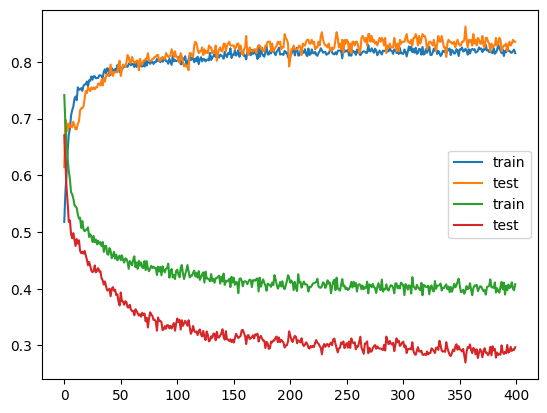

In [56]:
plt.plot(history_2.history['accuracy'], label = "train")
plt.plot(history_2.history['val_accuracy'], label = "test")
plt.plot(history_2.history['loss'], label = "train")
plt.plot(history_2.history['val_loss'], label = "test")

plt.legend()
plt.show()

In [57]:
model_2.evaluate(X_test_scaled,y_test)

40/40 [==============================] - 0s 3ms/step - loss: 0.3315 - accuracy: 0.8393


[0.33148643374443054, 0.8393417000770569]

In [58]:
metrics.accuracy_score(y_true= y_test, y_pred= (model_2.predict(X_test_scaled) > 0.5).astype("int32") )

40/40 [==============================] - 0s 3ms/step


0.8393416927899686

Porównanie accuracy dla obu sieci neuronowych

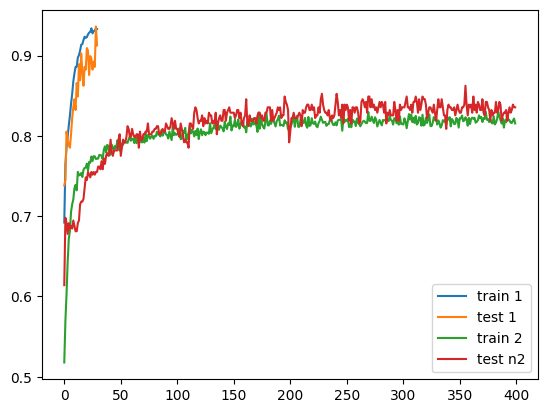

In [59]:
plt.plot(history.history['accuracy'], label = "train 1")
plt.plot(history.history['val_accuracy'], label = "test 1")
plt.plot(history_2.history['accuracy'], label = "train 2")
plt.plot(history_2.history['val_accuracy'], label = "test n2")

plt.legend()
plt.show()

Porównanie loss dla obu sieci neuronowych

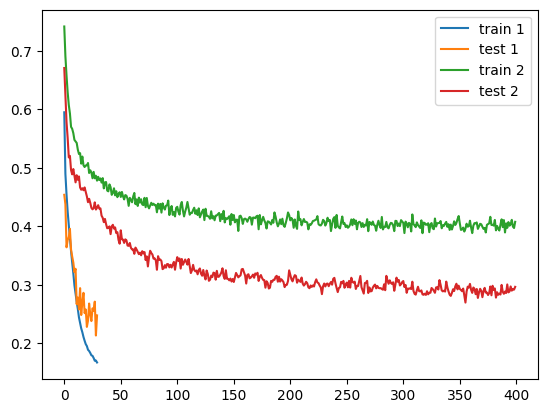

In [60]:
plt.plot(history.history['loss'], label = "train 1")
plt.plot(history.history['val_loss'], label = "test 1")
plt.plot(history_2.history['loss'], label = "train 2")
plt.plot(history_2.history['val_loss'], label = "test 2")

plt.legend()
plt.show()

### Podsumowanie

Pierwsza sieć uczyła się bez dodatkowych modyfikacji i usprawnień, w drugiej zastosowane zostały BatchNormalization oraz Dropout.

Sieć neuronowa nr 1 lepiej uczyła się na mniejszej liczby warstw oraz epok (im więcej epok tym obserwowano większy overfitting - rosnące loss na teście)
Natomiast sieć nr 2 osiągała wyższe wyniki na zwiększonej liczbie epok niż 1 oraz z użyciem większej liczby warstw.